# **<center> Regression from LMs' embeddings to GPS coordinates </center>**

## Imports

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import geopandas as gpd
from tqdm import tqdm

In [2]:
import shapely

In [3]:
from scipy import stats

In [4]:
from sklearn import linear_model

In [5]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

## Data Loading

In [6]:
models = ['bert','bertLarge','gpt2','roberta','mpnet']
contexts = ['I come from', 'He lives in', 'She moved to']
short_ctxts = ['come','lives','moved']

In [7]:
cities = pd.read_csv('./csv/worldcitiespop.csv',header=0,dtype={'AccentCity':'str','Region':'object'}).dropna().drop('Region',axis=1)
cities = cities[cities.Population>100000].reset_index(drop=True)
cities

,Country,City,AccentCity,Population,Latitude,Longitude
0,ae,abu dhabi,Abu Dhabi,603687.0,24.466667,54.366667
1,ae,dubai,Dubai,1137376.0,25.258172,55.304717
2,ae,sharjah,Sharjah,543942.0,25.357310,55.403304
3,af,baglan,Baglan,108481.0,36.130684,68.708286
4,af,gardez,Gardez,103732.0,33.597439,69.225922
...,...,...,...,...,...,...
3522,zw,gweru,Gweru,201879.0,-19.450000,29.816667
3523,zw,harare,Harare,2213701.0,-17.817778,31.044722
3524,zw,kadoma,Kadoma,100276.0,-18.350000,29.916667
3525,zw,kwekwe,Kwekwe,116332.0,-18.916667,29.816667


In [8]:
#more than 500'000 citizens
big_cities = cities[cities.Population > 5e5]
big_cities

,Country,City,AccentCity,Population,Latitude,Longitude
0,ae,abu dhabi,Abu Dhabi,603687.0,24.466667,54.366667
1,ae,dubai,Dubai,1137376.0,25.258172,55.304717
2,ae,sharjah,Sharjah,543942.0,25.357310,55.403304
8,af,kabul,Kabul,3043589.0,34.516667,69.183333
16,am,yerevan,Yerevan,1093499.0,40.181111,44.513611
...,...,...,...,...,...,...
3499,za,soweto,Soweto,1695094.0,-26.267812,27.858492
3501,za,tembisa,Tembisa,511671.0,-25.996363,28.226802
3517,zm,lusaka,Lusaka,1267458.0,-15.416667,28.283333
3520,zw,bulawayo,Bulawayo,897249.0,-20.150000,28.583333


In [9]:
capitals = pd.read_csv('./csv/country-capitals.csv').drop(['ContinentName','CountryCode'], axis=1)
capitals

,CountryName,CapitalName,Latitude,Longitude
0,Somaliland,Hargeisa,9.550000,44.050000
1,South Georgia and South Sandwich Islands,King Edward Point,-54.283333,-36.500000
2,French Southern and Antarctic Lands,Port-aux-Français,-49.350000,70.216667
3,Palestine,Jerusalem,31.766667,35.233333
4,Aland Islands,Mariehamn,60.116667,19.900000
...,...,...,...,...
237,Zimbabwe,Harare,-17.816667,31.033333
238,Northern Cyprus,North Nicosia,35.183333,33.366667
239,Hong Kong,Hong Kong,22.302711,114.177216
240,British Indian Ocean Territory,Diego Garcia,-7.300000,72.400000


In [10]:
countries = pd.read_csv('./csv/countries.csv')
countries

,Name,Code,Latitude,Longitude
0,Afghanistan,AF,33.0000,65.0
1,Åland Islands,AX,60.1500,20.0
2,Albania,AL,41.0000,20.0
3,Algeria,DZ,28.0000,3.0
4,American Samoa,AS,-14.3333,-170.0
...,...,...,...,...
244,Wallis and Futuna,WF,-13.3000,-176.2
245,Western Sahara,EH,24.5000,-13.0
246,Yemen,YE,15.0000,48.0
247,Zambia,ZM,-15.0000,30.0


In [11]:
datasets = {model_name : {ctx : pd.DataFrame(np.load('embd_files/'+model_name+'_'+ctx+'_cities.npy')) for ctx in short_ctxts} for model_name in models}
datasets_capitals = {model_name : {ctx : pd.DataFrame(np.load('embd_files/'+model_name+'_'+ctx+'_capitals.npy')) for ctx in short_ctxts} for model_name in models}
datasets_countries = {model_name : {ctx : pd.DataFrame(np.load('embd_files/'+model_name+'_'+ctx+'_countries.npy')) for ctx in short_ctxts} for model_name in models}
contexts.append('average of 3')
short_ctxts.append('avg')
for model_name in models :
    concat = pd.concat( (datasets[model_name]['come'],datasets[model_name]['lives'],datasets[model_name]['moved']) )
    datasets[model_name]['avg'] = concat.groupby(concat.index).mean()

for model_name in models :
    concat = pd.concat( (datasets_capitals[model_name]['come'],datasets_capitals[model_name]['lives'],datasets_capitals[model_name]['moved']) )
    datasets_capitals[model_name]['avg'] = concat.groupby(concat.index).mean()

for model_name in models :
    concat = pd.concat( (datasets_countries[model_name]['come'],datasets_countries[model_name]['lives'],datasets_countries[model_name]['moved']) )
    datasets_countries[model_name]['avg'] = concat.groupby(concat.index).mean()


## Tools and functions

In [12]:
def dist_from_gps(l1,L1,l2,L2):
    '''
    Compute distances in km between two points from their GPS coordinates
    ------------
    inputs :
    * l1 : latitude of the first point
    * L1 : longitude of the first point
    * l2 : latitude of the second point
    * L2 : longitude of the second point
    ------------
    output : distance in km
    '''
    a = np.sin( (l1-l2)*np.pi/360 )**2 + np.cos((l1)*np.pi/180) * np.cos((l2)*np.pi/180) * np.sin( (L1-L2)*np.pi/360 )**2
    c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d = 6371*c
    return(np.round(d,2))

In [13]:
def single_regression(reg_name, X_train, y_train, X_test=None, y_test=None,random_state_seed=0,test=False, alpha=0.1,mlp_iter=1000,mlp_size=100):
    '''
    Performs regression using the specified regressor, for GPS coordinates. 
    
    > Inputs : 
    * reg_name : name of the regressor to use among : mlp , lasso
    * X_train, y_train : datasets to use for training
    * X_test, y_test : datasets to use for testing, if test is True
    * random_state_seed : seed that will be used in regressor init.
    * test : boolean ; whether there is or not a testing phase.
    
    > Outputs :
    * res : tuple containing average error distance(s) and standard deviation(s) in kilometers on training datasets (and testing datasets if test is True and test sets provided)
    '''
    if test and (X_test is None or y_test is None):
        raise ValueError('In test mode, both X and y test datasets must be provided')
    if reg_name == 'mlp':
        reg = MLPRegressor(solver='adam',max_iter=mlp_iter,random_state=random_state_seed,hidden_layer_sizes=mlp_size) #MLP  Reg
    elif reg_name == 'lasso':
        reg = linear_model.Lasso(alpha=alpha,max_iter=10000,random_state=random_state_seed) #Lasso Reg
    reg.fit(X_train,y_train)
    preds = reg.predict(X_train)
    pairsGPS = np.concatenate( (preds,y_train), axis=1).T
    dists = dist_from_gps(pairsGPS[0],pairsGPS[1],pairsGPS[2],pairsGPS[3])
    mean, std = dists.mean().round(1),dists.std().round(1)
    res = [mean, std]
    if test :
        preds_test = reg.predict(X_test)
        pairsGPS_test = np.concatenate( (preds_test,y_test), axis=1).T
        dists_test = dist_from_gps(pairsGPS_test[0],pairsGPS_test[1],pairsGPS_test[2],pairsGPS_test[3])
        mean_test, std_test = dists_test.mean().round(1),dists_test.std().round(1)
        res.extend([mean_test,std_test])
    return tuple(res)

def summary_error_dists(X, y,n=10,regressors=['lasso','mlp'],rng_seed=0,random_state_seed=0, alpha=0.1,mlp_iter=1000, mlp_size=100, output=False,display=True):
    rng = np.random.default_rng(seed=rng_seed)
    if output :
        out = {'full':{},'train':{},'test':{}}
    #Full
    if display:
        print('------------------------FULL---------------------------')
    for reg_name in regressors :
        if display :
            print('\r{} regressor ...'.format(reg_name),end='')
            sys.stdout.flush()
        mean, std = single_regression(reg_name, X, y, random_state_seed=random_state_seed, alpha=alpha, mlp_iter=mlp_iter, mlp_size=mlp_size)
        if display:
            print('\r{} :  mean distance : {}  [std : {} ]'.format(reg_name, mean, std))
        if output:
            out['full'][reg_name] = (mean,std)
    #Train test
    if display:
        print('---------------------TRAIN/TEST------------------------')
    for reg_name in regressors :
        if reg_name == 'mlp' :
            n_trials = 1
        else:
            n_trials = n
        means, stds, test_means, test_stds = np.empty((4,n_trials))
        for i in range(n_trials):
            test_idx = rng.choice(y.index,int(0.2*len(y)))
            y_train, y_test = y.drop(test_idx,axis=0), y.loc[test_idx]
            X_train , X_test = X.drop(test_idx,axis=0), X.loc[test_idx] 
            
            if display:
                print('\r{} : trial {} among {}'.format(reg_name, i+1, n_trials),end='')
                sys.stdout.flush()
            means[i], stds[i], test_means[i] , test_stds[i] = single_regression(reg_name, X_train, y_train, X_test = X_test, y_test = y_test , 
                                                                                random_state_seed=random_state_seed, test=True, 
                                                                                alpha=alpha, mlp_iter=mlp_iter, mlp_size=mlp_size)
        if display:
            print('\r{} :  train mean distance : {}  [std : {} ] ; test mean distance : {}  [std : {} ]'.format(
                reg_name, means.mean().round(1), stds.mean().round(1), test_means.mean().round(1), test_stds.mean().round(1)
                ))
        if output:
            out['train'][reg_name]= (means.mean().round(1), stds.mean().round(1))
            out['test'][reg_name]= (test_means.mean().round(1), test_stds.mean().round(1))
    if output:
        return out
    

## For all cities, predict Lat and Long from LMs' embeddings with MLP Regressor

### Computing average error distance between real point and predicted point

(Error distance is computed from a test set)

In [10]:
y = cities[['Latitude','Longitude']]
test_indexes = np.random.choice(cities.index,int(0.2*len(cities)))
y_train, y_test = y.drop(test_indexes,axis=0), y.loc[test_indexes]

In [43]:
predictors = { model : { ctx : MLPRegressor(max_iter=2000,solver='adam') for ctx in short_ctxts} for model in models }

for model in models:
    for ctx in short_ctxts:
        #create datasets
        X = datasets[model][ctx] #all
        X_train = X.drop(test_indexes,axis=0) #all except test
        X_test = X.loc[test_indexes] #test
        #train regressor
        reg = predictors[model][ctx]
        reg.fit(X_train,y_train)
        #predict test Lat/Long
        preds = reg.predict(X_test)
        #Compute distances in km
        pairsGPS = np.concatenate( (preds,y_test), axis=1).T
        dists = dist_from_gps(pairsGPS[0],pairsGPS[1],pairsGPS[2],pairsGPS[3])
        print(model + ' - ' + ctx + '   error distance : ' + str(int(dists.mean().round()) ) +' km' )
    print('------------------------------')

bert - fav   error distance : 4384 km
bert - lives   error distance : 4426 km
bert - moved   error distance : 4421 km
bert - avg   error distance : 4343 km
------------------------------
roberta - fav   error distance : 4609 km
roberta - lives   error distance : 4583 km
roberta - moved   error distance : 4521 km
roberta - avg   error distance : 4443 km
------------------------------
mpnet - fav   error distance : 5176 km
mpnet - lives   error distance : 5005 km
mpnet - moved   error distance : 5029 km
mpnet - avg   error distance : 5350 km
------------------------------


4220.3 3321.3


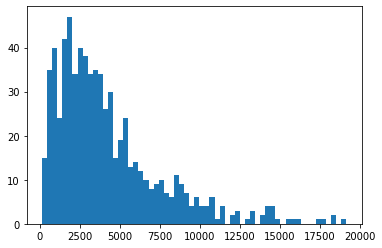

In [10]:
model = 'bert'
ctx = 'fav'
reg = predictors[model][ctx]
preds = reg.predict(datasets[model][ctx].loc[test_indexes])

pairsGPS = np.concatenate( (preds,y_test), axis=1).T
dists = dist_from_gps(pairsGPS[0],pairsGPS[1],pairsGPS[2],pairsGPS[3])
print(dists.mean().round(1),dists.std().round(1))
plt.hist(dists,bins=60)
plt.show()

### Compare with Randomly Choosen Lat. and Long.

In [40]:
#Set to True if the range should be scaled by existing values - False if range should be fully ranged
existing_range = True

if existing_range:
    randl = np.random.uniform(min(y.Latitude),max(y.Latitude),len(cities)).reshape((len(cities),1))
    randL = np.random.uniform(min(y.Longitude),max(y.Longitude),len(cities)).reshape((len(cities),1))
else:
    randl = np.random.uniform(-90.0,90.0,len(cities)).reshape((len(cities),1))
    randL = np.random.uniform(-180.0,180.0,len(cities)).reshape((len(cities),1))

y_random = pd.DataFrame(np.concatenate( (randl,randL), axis=1),columns=('Latitude','Longitude'))

In [41]:
y_random_train, y_random_test = y_random.drop(test_indexes,axis=0), y_random.loc[test_indexes]

for model in models:
    for ctx in short_ctxts:
        #create datasets
        X = datasets[model][ctx] #all
        X_train = X.drop(test_indexes,axis=0) #all except test
        X_test = X.loc[test_indexes] #test
        #train regressor
        reg = MLPRegressor(max_iter=2000,solver='adam')
        reg.fit(X_train,y_random_train)
        #predict test Lat/Long
        preds = reg.predict(X_test)
        #Compute distances in km
        pairsGPS = np.concatenate( (preds,y_random_test), axis=1).T
        dists = dist_from_gps(pairsGPS[0],pairsGPS[1],pairsGPS[2],pairsGPS[3])
        print(model + ' - ' + ctx + '   error distance : ' + str(int(dists.mean().round()) ) +' km' )
    print('------------------------------')

bert - fav   error distance : 9410 km
bert - lives   error distance : 9612 km
bert - moved   error distance : 9853 km
bert - avg   error distance : 9754 km
------------------------------
roberta - fav   error distance : 9659 km
roberta - lives   error distance : 9538 km
roberta - moved   error distance : 9496 km
roberta - avg   error distance : 9588 km
------------------------------
mpnet - fav   error distance : 9894 km
mpnet - lives   error distance : 9815 km
mpnet - moved   error distance : 10168 km
mpnet - avg   error distance : 9975 km
------------------------------


***Remark*** : The MLP regressor performs significantly better-than-random using LM embeddings. May be something in the LM representations that helps predictions.

### Ranking from distance between real city point and predicted point

In [28]:
model = 'bert'
ctx = 'avg'
reg = MLPRegressor(max_iter=1000,solver='adam').fit(datasets[model][ctx],y)

693.9 835.1


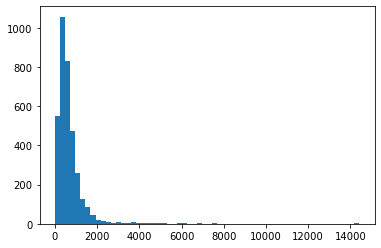

In [29]:
preds_all = reg.predict(datasets[model][ctx])
pairsGPS_all = np.concatenate( (preds_all,y), axis=1).T
dists_all = dist_from_gps(pairsGPS_all[0],pairsGPS_all[1],pairsGPS_all[2],pairsGPS_all[3])
print(dists_all.mean().round(1),dists_all.std().round(1))
plt.hist(dists_all,bins=60)
plt.show()

In [130]:
order = dists_all.argsort()
full = np.hstack( (cities.iloc[:,2:].loc[order],preds_all[order],np.expand_dims(dists_all[order],axis=1),np.expand_dims(np.arange(1,len(cities)+1),axis=1) ))
summary = pd.DataFrame(data= full, columns=['AccentCity','Population','Latitude','Longitude','PredLat','PredLong','Distance','Rank'] ,index=order)

In [131]:
summary.head(20)

,AccentCity,Population,Latitude,Longitude,PredLat,PredLong,Distance,Rank
1806,Ulhasnagar,516625.0,19.216667,73.15,19.241121,73.273082,13.21,1
2664,Bialystok,291855.0,53.133333,23.15,53.042565,23.285058,13.54,2
2529,Juliaca,247949.0,-15.5,-70.133333,-15.674419,-70.176971,19.95,3
1743,Rajkot,1177434.0,22.3,70.783333,22.27152,70.57682,21.48,4
2159,Klaipeda,192314.0,55.717222,21.1175,55.744395,20.755634,22.86,5
1560,Etawah,257472.0,26.7769,79.0239,26.979241,78.974292,23.03,6
3046,Zonguldak,100281.0,41.451392,31.793053,41.414162,32.082012,24.44,7
2892,Volgograd,1010331.0,48.71939,44.501835,48.49539,44.295005,29.18,8
157,Bragança Paulista,125099.0,-22.95,-46.566667,-22.709602,-46.69879,29.96,9
1869,Neyshabur,220954.0,36.213288,58.795755,35.92855,58.672261,33.55,10


### Comparison with city size

In [132]:
summary.sort_values('Population',ascending=False).head(20)

,AccentCity,Population,Latitude,Longitude,PredLat,PredLong,Distance,Rank
2096,Tokyo,31480498.0,35.685,139.751389,34.369622,137.621034,242.93,676
715,Shanghai,14608512.0,31.045556,121.399722,34.666005,119.187542,452.47,1773
1518,Bombay,12692717.0,18.975,72.825833,20.137477,69.591106,362.74,1300
2629,Karachi,11627378.0,24.9056,67.0822,21.218304,63.016874,583.94,2355
1705,New Delhi,10928270.0,28.6,77.2,29.218839,73.978194,321.05,1077
1544,Delhi,10928270.0,28.666667,77.216667,27.68302,72.813762,445.18,1734
2579,Manila,10443877.0,14.6042,120.9822,15.37711,113.323043,827.1,2985
2810,Moscow,10381288.0,55.752222,37.615556,51.5643,36.054757,476.86,1890
2127,Seoul,10323448.0,37.5985,126.9783,37.049717,123.198102,339.76,1173
321,São Paulo,10021437.0,-23.473293,-46.665803,-24.735511,-47.135745,148.24,233


In [135]:
print("Correlation between city size and ranking in prediction :\n",stats.pearsonr(summary.Population,summary.Rank)[0].round(4))

Correlation between city size and ranking in prediction :
 -0.0481


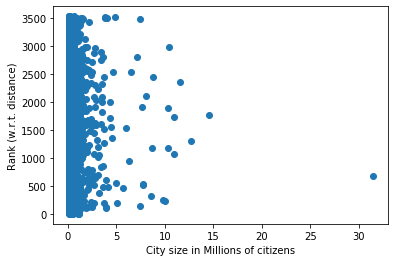

In [150]:
plt.scatter(summary.Population/1e6,summary.Rank)
plt.xlabel('City size in Millions of citizens')
plt.ylabel('Rank (w.r.t. distance)')
plt.show()

***Remark*** : It seems to have no correlation between city size and how good the prediction is.

## Train/Test with all cities

In [101]:
rng = np.random.default_rng(seed=0)
n = 1
means = np.empty(n)
stds = np.empty(n)
#X = datasets[model][ctx]
for i in range(n):
    test_idx = rng.choice(big_cities.index,int(0.2*len(big_cities)))
    y_train, y_test = y_big.drop(test_idx,axis=0), y_big.loc[test_idx]

    X_train = X_big.drop(test_idx,axis=0) #all except test
    X_test = X_big.loc[test_idx] #test

    reg = MLPRegressor(solver='adam',max_iter=1000).fit(X_train,y_train) #MLP regressor
    #reg = linear_model.Lasso(alpha=0.01,max_iter=1000).fit(X_train,y_train) #Lasso linear regressor
    
    
    preds_T = reg.predict(X_train)
    pairsGPS_T = np.concatenate( (preds_T,y_train), axis=1).T
    dists_T = dist_from_gps(pairsGPS_T[0],pairsGPS_T[1],pairsGPS_T[2],pairsGPS_T[3])
    
    means[i], stds[i] = dists_T.mean().round(1),dists_T.std().round(1)

In [105]:
preds_T = reg.predict(X_train)
pairsGPS_T = np.concatenate( (preds_T,y_train), axis=1).T
dists_T = dist_from_gps(pairsGPS_T[0],pairsGPS_T[1],pairsGPS_T[2],pairsGPS_T[3])

means[i], stds[i] = dists_T.mean().round(1),dists_T.std().round(1)

535.5 754.5


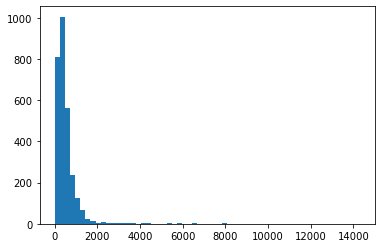

In [106]:
print(means.mean().round(1),stds.mean().round(1))
plt.hist(dists_T,bins=60)
plt.show()

## Comparing the different data sources : city names, capital names or country names and size of city

### All cities

In [24]:
model = 'bert'
ctx = 'avg'
y = cities[['Latitude','Longitude']]
X = datasets[model][ctx]
sum_all = summary_error_dists(X, y,output=True)

------------------------FULL---------------------------
lasso :  mean distance : 3259.2  [std : 2755.2 ]
mlp :  mean distance : 548.0  [std : 801.1 ]
---------------------TRAIN/TEST------------------------
lasso :  train mean distance : 3233.5  [std : 2723.2 ] ; test mean distance : 3515.6  [std : 2881.6 ]
mlp :  train mean distance : 402.3  [std : 696.1 ] ; test mean distance : 4064.6  [std : 3319.7 ]


### Cities with more than 500k citizens

In [98]:
threshold_bigness = 5e5
y_big = y[cities.Population > threshold_bigness]
X_big = X[cities.Population > threshold_bigness]
sum_big = summary_error_dists(X_big, y_big, rng_seed=42,output=True, regressors=['mlp'], mlp_size=10, mlp_iter=1000)

------------------------FULL---------------------------
mlp :  mean distance : 1242.9  [std : 914.8 ]
---------------------TRAIN/TEST------------------------
mlp : trial 1 among 1

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


mlp :  train mean distance : 1064.2  [std : 751.5 ] ; test mean distance : 2651.5  [std : 2038.4 ]


/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Cities with more than 1M citizens

In [28]:
threshold_biggest = 1e6
y_bigst = y[cities.Population > threshold_biggest]
X_bigst = X[cities.Population > threshold_biggest]
sum_bigst = summary_error_dists(X_bigst, y_bigst,output=True,mlp_iter=2000)

------------------------FULL---------------------------
lasso :  mean distance : 1137.4  [std : 839.9 ]
mlp :  mean distance : 19.8  [std : 58.9 ]
---------------------TRAIN/TEST------------------------
lasso :  train mean distance : 979.1  [std : 737.3 ] ; test mean distance : 3252.7  [std : 2457.6 ]
mlp :  train mean distance : 37.9  [std : 68.9 ] ; test mean distance : 3327.6  [std : 2147.7 ]


### Country capitals

In [24]:
model = 'bert'
ctx = 'avg'
y_cap = capitals[['Latitude','Longitude']]
X_cap = datasets_capitals[model][ctx]
sum_cap = summary_error_dists(X_cap, y_cap,output=True)

------------------------FULL---------------------------
lasso :  mean distance : 1144.4  [std : 1312.3 ]
mlp :  mean distance : 526.0  [std : 1207.4 ]
---------------------TRAIN/TEST------------------------
lasso :  train mean distance : 928.8  [std : 1132.8 ] ; test mean distance : 6612.3  [std : 4252.4 ]
mlp :  train mean distance : 144.1  [std : 1325.4 ] ; test mean distance : 5002.7  [std : 3916.9 ]


### Country centers

In [22]:
model = 'bert'
ctx = 'avg'
y_countries = countries[['Latitude','Longitude']]
X_countries = datasets_countries[model][ctx]
sum_countries = summary_error_dists(X_countries, y_countries, mlp_iter=2000,output=True)

------------------------FULL---------------------------
lasso :  mean distance : 1389.6  [std : 1060.1 ]
mlp :  mean distance : 10.6  [std : 11.2 ]
---------------------TRAIN/TEST------------------------
lasso :  train mean distance : 1147.1  [std : 878.4 ] ; test mean distance : 5336.4  [std : 4027.6 ]
mlp :  train mean distance : 1375.3  [std : 1209.5 ] ; test mean distance : 3297.9  [std : 3013.9 ]


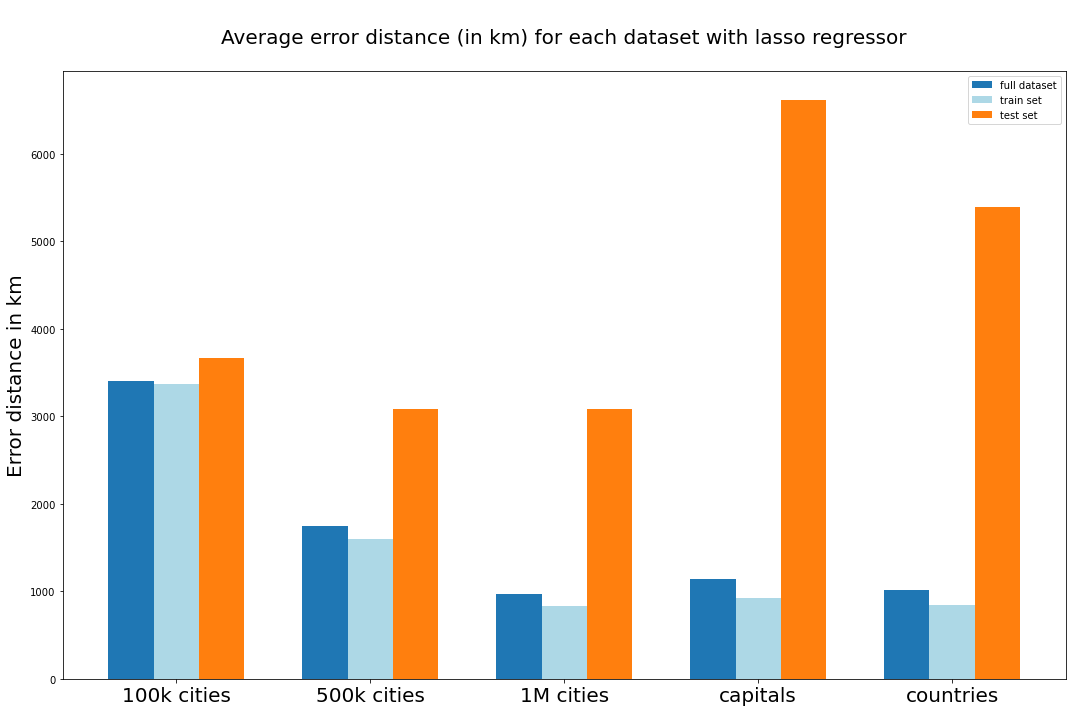

In [79]:
summaries = [sum_all,sum_big,sum_bigst,sum_cap,sum_countries]
reg_name = 'lasso'
labels = ['100k cities', '500k cities', '1M cities', 'capitals', 'countries']
full = ([s['full'][reg_name][0] for s in summaries],[s['full'][reg_name][1] for s in summaries])
train = ([s['train'][reg_name][0] for s in summaries],[s['train'][reg_name][1] for s in summaries])
test = ([s['test'][reg_name][0] for s in summaries],[s['test'][reg_name][1] for s in summaries])


locs = np.arange(len(labels))*1.5  # label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))
fig.set_facecolor('white')
rects1 = ax.bar(locs - width, full[0], width, label='full dataset')
rects2 = ax.bar(locs, train[0], width, label='train set',color='lightblue')
rects3 = ax.bar(locs + width, test[0], width, label='test set')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Error distance in km', fontdict = {'fontsize' : 20})
ax.set_title('\nAverage error distance (in km) for each dataset with '+reg_name+' regressor\n', fontdict = {'fontsize' : 20})
ax.set_xticks(locs)
ax.set_xticklabels(labels, fontdict = {'fontsize' : 20})
ax.legend()

fig.tight_layout()

plt.savefig(reg_name+'_summary.png',dpi=200, facecolor=fig.get_facecolor())
plt.show()

### Compared to randomly choosen...

In [108]:
base = y_cap
size=len(base)
y_random = pd.DataFrame(np.concatenate( (np.random.uniform(min(base.Latitude),max(base.Latitude),size).reshape((size,1)),
                                         np.random.uniform(min(base.Longitude),max(base.Longitude),size).reshape((size,1))), axis=1),
                        columns=('Latitude','Longitude'),index=base.index)

model = 'bert'
ctx = 'avg'
sum_all = summary_error_dists(X_cap, y_random)

------------------------FULL---------------------------
lasso :  mean distance : 1298.8  [std : 710.7 ]
mlp :  mean distance : 116.0  [std : 280.8 ]
---------------------TRAIN/TEST------------------------
lasso :  train mean distance : 1036.2  [std : 563.8 ] ; test mean distance : 9923.2  [std : 4413.2 ]
mlp :  train mean distance : 28.0  [std : 220.0 ] ; test mean distance : 9586.4  [std : 4113.2 ]


In [20]:
y_cap = capitals[['Latitude','Longitude']]
X_cap = datasets_capitals['bert']['avg']

summary_error_dists(X_cap,y_cap,output=True,display=False,regressors=['lasso'])

{'full': {'lasso': (1443.0, 1424.4)},
 'train': {'lasso': (1191.8, 1219.7)},
 'test': {'lasso': (6312.7, 4431.9)}}

## Comparison between models

In [187]:
models_to_compare = ['bert','bertLarge','gpt2','roberta']
regressors = ['lasso','mlp']
ctx = 'avg'
y = cities[['Latitude','Longitude']]
y_big = y[cities.Population > 5e5]
y_bigst = y[cities.Population > 1e6]
y_countries = countries[['Latitude','Longitude']]
y_cap = capitals[['Latitude','Longitude']]



Ys = [y,y_big,y_bigst,y_cap,y_countries]

test_error_dists = np.empty( (len(regressors),len(models_to_compare),len(Ys)) )

for i,model in enumerate(models_to_compare):
    Xs = [datasets[model][ctx]]
    Xs.append(Xs[0][cities.Population > 5e5])
    Xs.append(Xs[0][cities.Population > 1e6])
    Xs.extend([datasets_capitals[model][ctx],datasets_countries[model][ctx]])
    
    
    for j,features in tqdm(enumerate(Xs),total=len(Xs),desc=model, unit_scale=True,file=sys.stdout):
        target = Ys[j]
        dic = summary_error_dists(features, target,output=True,display=False,regressors=regressors,mlp_iter=3000)
        for k,reg in enumerate(regressors):
            test_error_dists[k][i][j]=dic['test'][reg][0]

bert: 100%|██████████| 5.00/5.00 [03:15<00:00, 39.1s/it]
bertLarge: 100%|██████████| 5.00/5.00 [03:24<00:00, 41.0s/it]
gpt2: 100%|██████████| 5.00/5.00 [03:54<00:00, 47.0s/it]
roberta: 100%|██████████| 5.00/5.00 [04:29<00:00, 53.9s/it]


In [42]:
test_error_dists

array([[[4090.4, 3255.8, 3308.6, 6482.2, 4110.4],
        [3600.9, 2096. , 2173.2, 5056.4, 3436.4],
        [4936.6, 4554.6, 4919. , 6251. , 5753.6],
        [4471. , 3562.2, 3380.8, 6093.2, 4711.1]]])

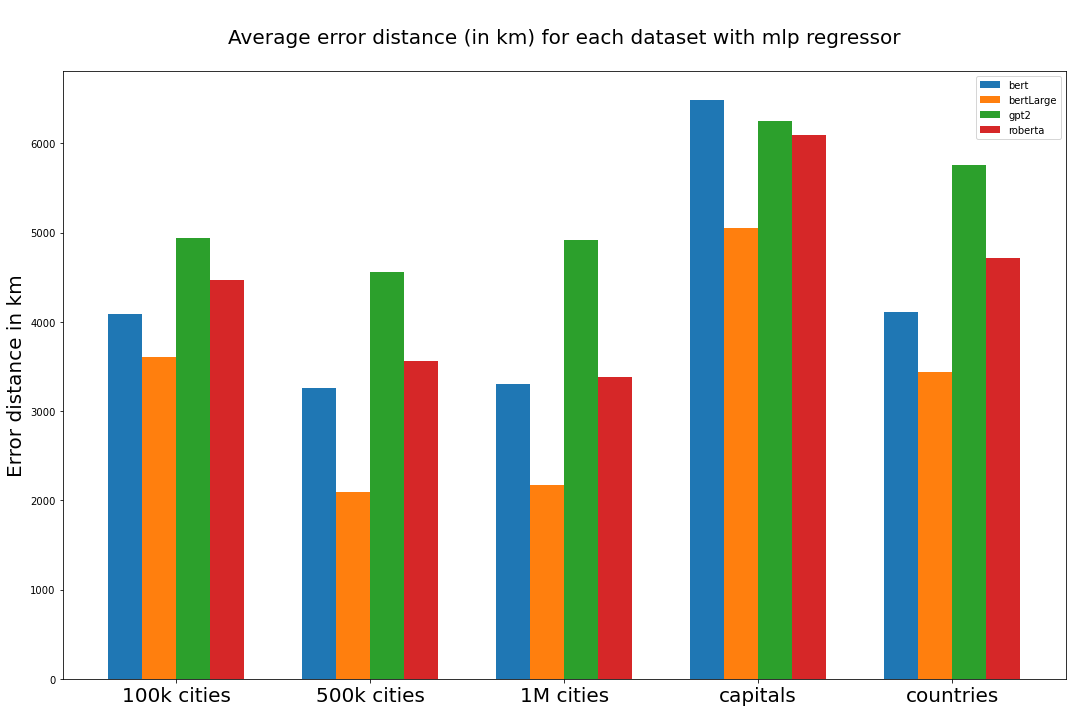

In [43]:
reg_name = 'mlp'
ind_reg = regressors.index(reg_name)
labels = ['100k cities', '500k cities', '1M cities', 'capitals', 'countries']

locs = np.arange(len(labels))*0.5*len(models_to_compare)  # label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(15,10))
fig.set_facecolor('white')
for i,model in enumerate(models_to_compare):
    if len(models_to_compare)%2==0:
        rect = ax.bar(locs + (i-len(models_to_compare)//2+0.5)*width, test_error_dists[ind_reg][i], width, label=model)
    else:
        rect = ax.bar(locs + (i-len(models_to_compare)//2)*width, test_error_dists[ind_reg][i], width, label=model)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Error distance in km', fontdict = {'fontsize' : 20})
ax.set_title('\nAverage error distance (in km) for each dataset with '+reg_name+' regressor\n', fontdict = {'fontsize' : 20})
ax.set_xticks(locs)
ax.set_xticklabels(labels, fontdict = {'fontsize' : 20})
ax.legend()

fig.tight_layout()

plt.savefig(reg_name+'_test_summary.png',dpi=200, facecolor=fig.get_facecolor())
plt.show()

## Visualisations of data sources

In [44]:
# Access built-in Natural Earth data via GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

### All cities

<AxesSubplot:>

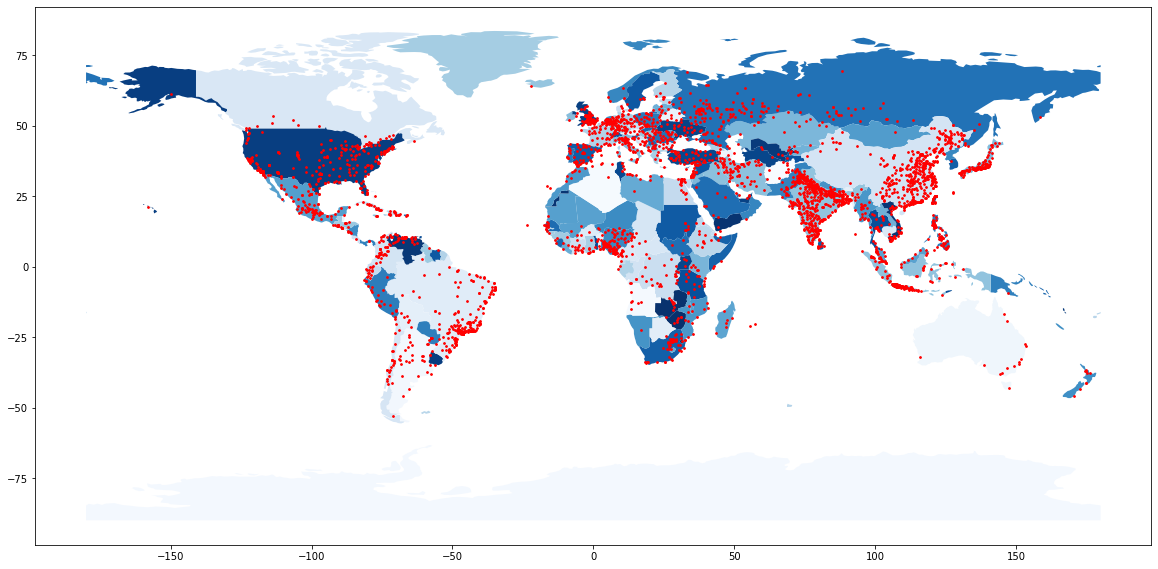

In [39]:
# Get a list (dataframe) of cities
cities_points = gpd.geoseries.GeoSeries([shapely.geometry.point.Point(xy) for xy in zip(y['Longitude'],y['Latitude'])])
cities_points_list = pd.concat([cities['AccentCity'], cities_points], axis=1)

# Plot the results
base = world.plot(column = 'name', cmap = 'Blues', figsize=(20,10))
cities_points.plot(ax = base, marker = 'o', color = 'red', markersize = 3)

### Big cities

<AxesSubplot:>

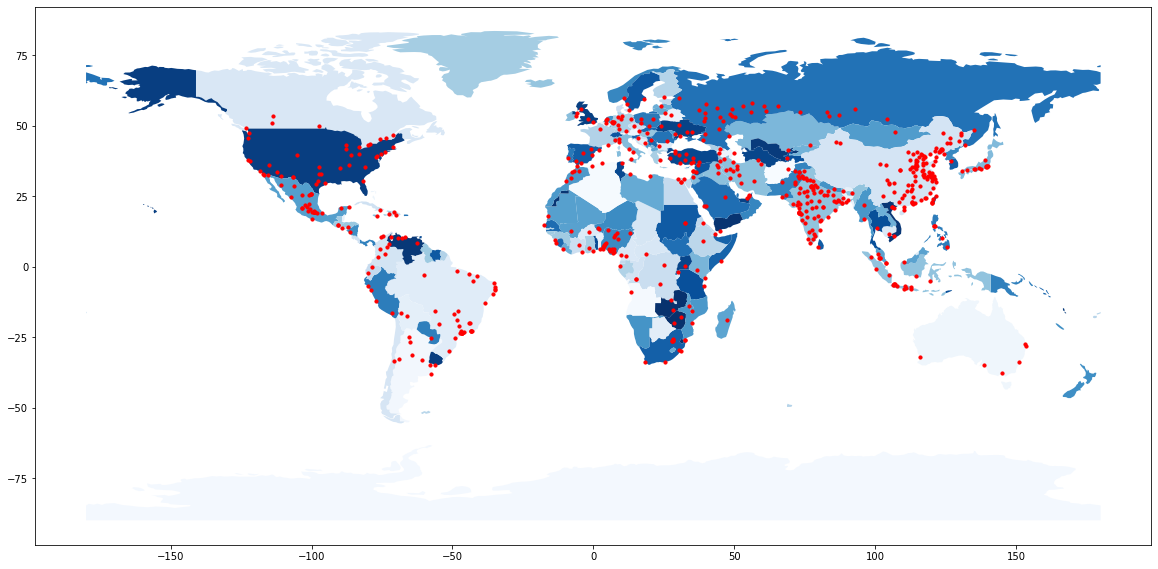

In [41]:
# Get a series of big cities
cities_points_big = gpd.geoseries.GeoSeries([shapely.geometry.point.Point(xy) for xy in zip(y_big['Longitude'],y_big['Latitude'])])

# Plot the results
base = world.plot(column = 'name', cmap = 'Blues', figsize=(20,10))
cities_points_big.plot(ax = base, marker = 'o', color = 'red', markersize = 10)

### Biggest cities

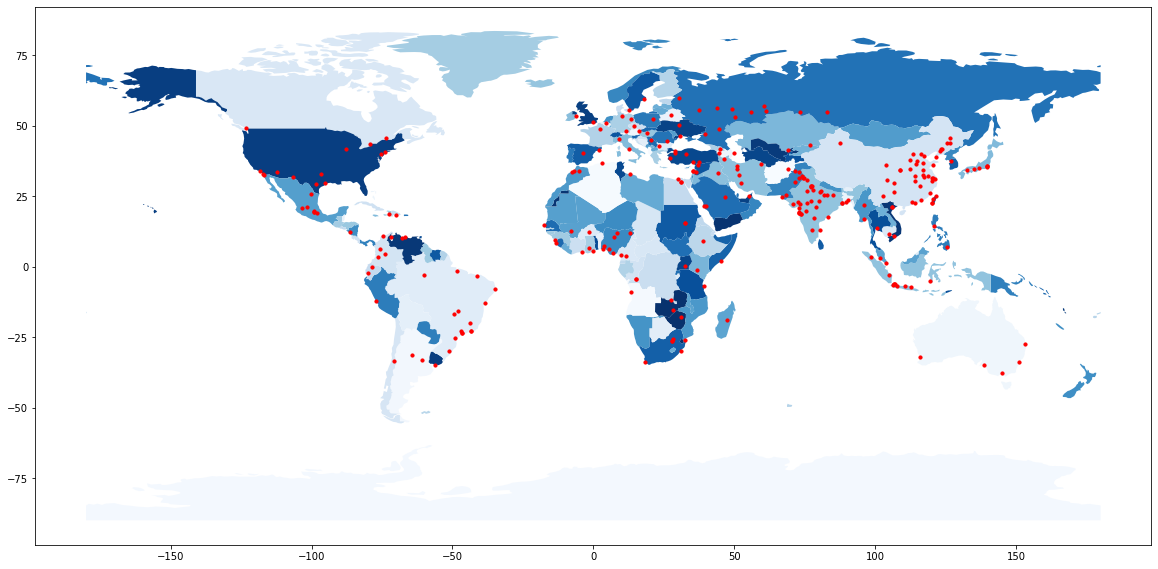

In [112]:
# Get a series of biggest cities
cities_points_bigst = gpd.geoseries.GeoSeries([shapely.geometry.point.Point(xy) for xy in zip(y_bigst['Longitude'],y_bigst['Latitude'])])

# Plot the results
base = world.plot(column = 'name', cmap = 'Blues', figsize=(20,10))
cities_points_bigst.plot(ax = base, marker = 'o', color = 'red', markersize = 10)
plt.savefig('1M_cities.png', dpi=300)

### Capitals

<AxesSubplot:>

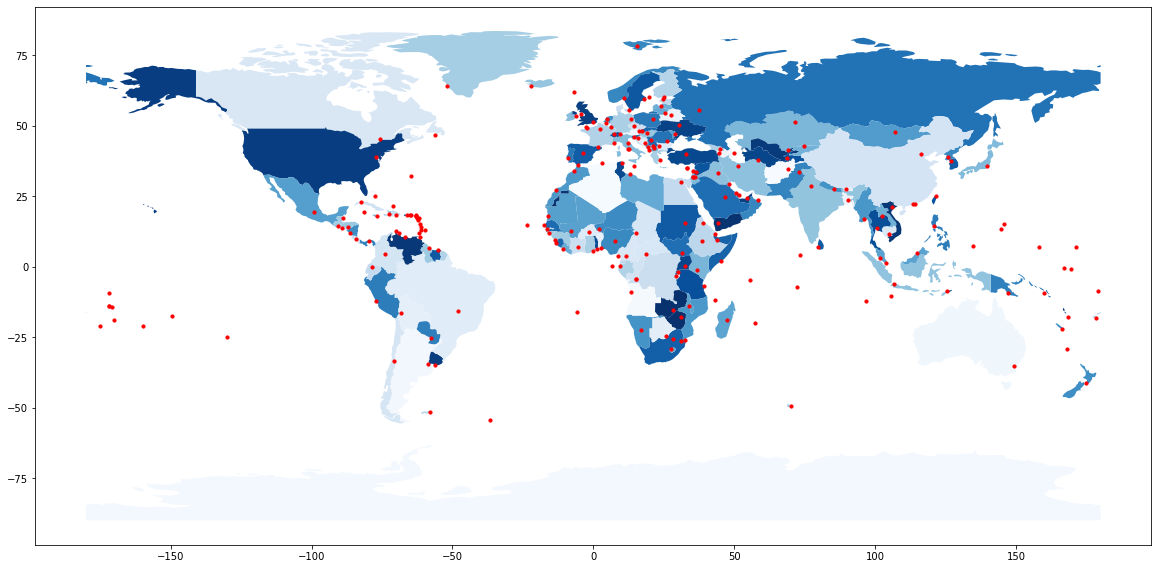

In [47]:
# Get a list (dataframe) of capitals
capitals_points = gpd.geoseries.GeoSeries([shapely.geometry.point.Point(xy) for xy in zip(y_cap['Longitude'],y_cap['Latitude'])])
capitals_list = pd.concat([capitals['CapitalName'], capitals_points], axis=1)

# Plot the results
base = world.plot(column = 'name', cmap = 'Blues', figsize=(20,10))
capitals_points.plot(ax = base, marker = 'o', color = 'red', markersize = 10)

### Country centroids

<AxesSubplot:>

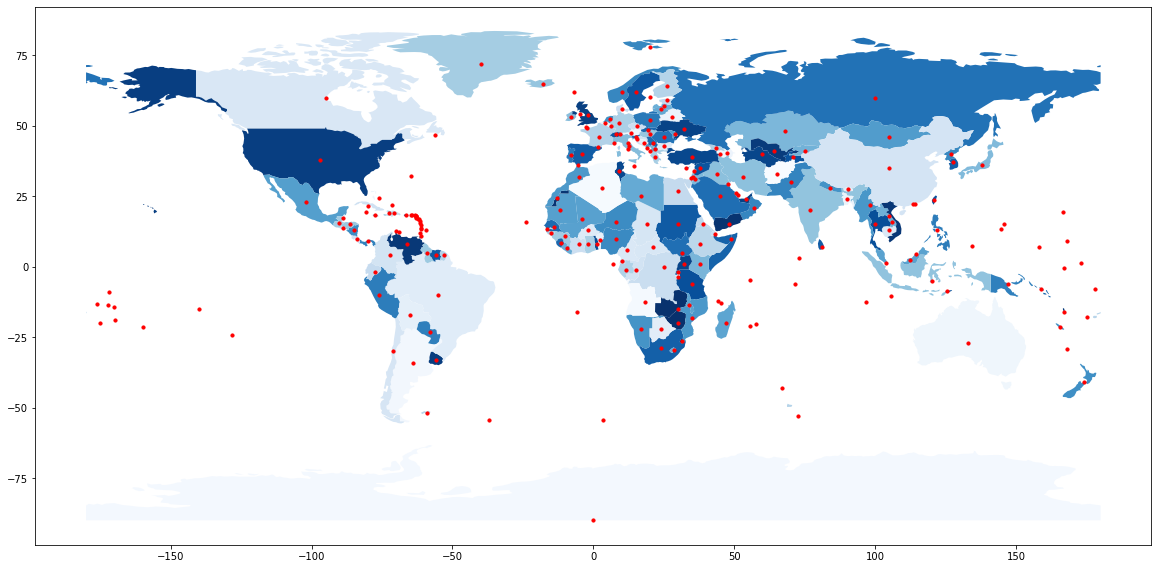

In [68]:
# Get a list (dataframe) of country centroids
centroids = gpd.geoseries.GeoSeries([shapely.geometry.point.Point(xy) for xy in zip(countries['Longitude'],countries['Latitude'])])
centroid_list = pd.concat([countries['Name'], centroids], axis=1)

# Plot the results
base = world.plot(column = 'name', cmap = 'Blues', figsize=(20,10))
centroids.plot(ax = base, marker = 'o', color = 'red', markersize = 10)

## Creation of an handcurated dataset of non-capital cities with > 1M citizens

In [124]:
bigst_cities = cities[cities.Population > 1e6]
to_keep = pd.DataFrame(columns=cities.columns)
for city in bigst_cities.iterrows():
    if city[1].AccentCity not in capitals.CapitalName.unique():
        to_keep = to_keep.append(city[1])

In [130]:
to_remove = []
removed_codes = []
for city in to_keep.iterrows():
    city_count = city[1].Country
    if city_count not in removed_codes:
        city_name=city[1].AccentCity
        remove = input(city_count+' '+city_name)
        if remove == '1':
            to_remove.append(city[1].name)
            removed_codes.append(city_count)

ae Dubai 
ar Cordoba 
ar Rosario 
au Adelaide 
au Brisbane 
au Melbourne 
au Perth 
au Sydney 
bd Khulna 
br Belém 
br Belo Horizonte 
br Brasília 1
ca Montreal 
ca Toronto 
ca Vancouver 
cd Lubumbashi 
ci Abidjan 
cm Douala 
cm Yaoundé 1
cn Anshan 
cn Changchun 
cn Chengdu 
cn Chongqing 
cn Dalian 
cn Datong 
cn Fushun 
cn Fuzhou 
cn Guangzhou 
cn Guiyang 
cn Handan 
cn Hangzhou 
cn Harbin 
cn Hefei 
cn Huainan 
cn Jilin 
cn Jinan 
cn Kunming 
cn Lanzhou 
cn Luoyang 
cn Nanchang 
cn Nanjing 
cn Peking 1
co Barranquilla 
co Bogotá 1
de Hamburg 
de Munich 
ec Guayaquil 
eg Alexandria 
eg Gizeh 
es Barcelona 
et Addis Abeba 1
gh Kumasi 
id Bandung 
id Bekasi 
id Depok 
id Makasar 
id Medan 
id Palembang 
id Semarang 
id Surabaya 
id Tangerang 
in Agra 
in Ahmadabad 
in Allahabad 
in Amritsar 
in Aurangabad 
in Bangalore 
in Bhopal 
in Bombay 
in Calcutta 
in Delhi 
in Faridabad 
in Ghaziabad 
in Haora 
in Hyderabad 
in Indore 
in Jabalpur 
in Jaipur 
in Kalyan 
in Kanpur 
in Lakhnau 
in 

In [132]:
NonCap1M = to_keep
for i in to_remove:
    NonCap1M.drop(i,axis=0,inplace=True)

In [133]:
NonCap1M

,Country,City,AccentCity,Population,Latitude,Longitude
1,ae,dubai,Dubai,1137376.0,25.258172,55.304717
27,ar,cordoba,Cordoba,1441007.0,-31.413496,-64.181052
41,ar,rosario,Rosario,1218497.0,-32.946818,-60.639317
59,au,adelaide,Adelaide,1074168.0,-34.928661,138.598633
61,au,brisbane,Brisbane,1843459.0,-27.471010,153.024292
...,...,...,...,...,...,...
3443,vn,ho chi minh city,Ho Chi Minh City,3467426.0,10.750000,106.666667
3471,za,cape town,Cape Town,3433504.0,-33.925839,18.423218
3472,za,durban,Durban,3120340.0,-29.857896,31.029198
3475,za,johannesburg,Johannesburg,2026466.0,-26.205171,28.049815


#### This dataset being < 200, we use cross validation

In [140]:
from sklearn.model_selection import cross_val_score

In [145]:
def scorer(estimator,X,y):
    preds = estimator.predict(X)
    pairsGPS = np.concatenate( (preds,y), axis=1).T
    dists = dist_from_gps(pairsGPS[0],pairsGPS[1],pairsGPS[2],pairsGPS[3])
    return dists.mean().round(1)

In [188]:
y_noncap1M = NonCap1M[ ['Latitude','Longitude'] ]
ctx='avg'

lasso_cv_scores = []
mlp_cv_scores = []

for model in tqdm(models_to_compare,desc='cross_validation',file=sys.stdout,position=1):
    X_noncap1M = datasets[model][ctx].iloc[NonCap1M.index]
    lasso_cv_scores.append(cross_val_score(linear_model.Lasso(alpha=0.1,random_state=0,max_iter=2000), X_noncap1M, y_noncap1M, cv=5,scoring=scorer).mean())
    mlp_cv_scores.append(cross_val_score(MLPRegressor(random_state=0,max_iter=3000), X_noncap1M, y_noncap1M, cv=5,scoring=scorer).mean())
    


cross_validation:  50%|█████     | 2/4 [01:05<01:04, 32.38s/it]

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298.1763053819959, tolerance: 84.31884182722244
  positive)



cross_validation: 100%|██████████| 4/4 [02:03<00:00, 30.93s/it]


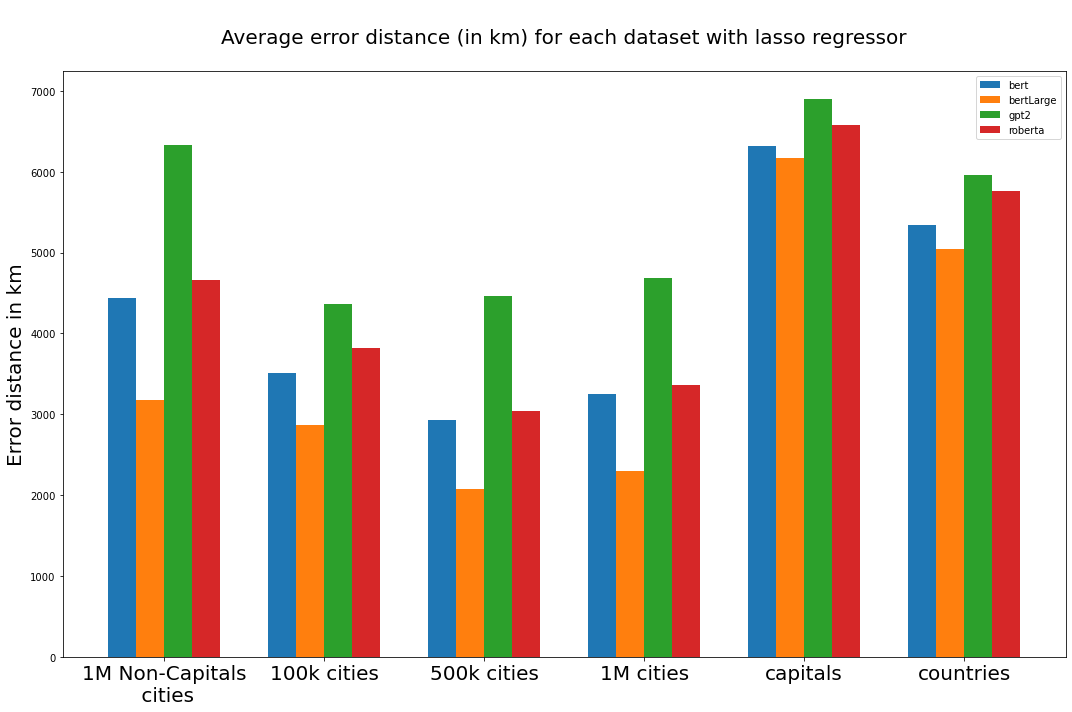

In [194]:
reg_name = 'lasso'
ind_reg = regressors.index(reg_name)
if reg_name=='mlp':
    cv_scores = mlp_cv_scores
elif reg_name=='lasso':
    cv_scores = lasso_cv_scores
test_errors_expended = np.concatenate([np.array(cv_scores).reshape((len(cv_scores),1)),test_error_dists[ind_reg]],axis=1)
labels = ['1M Non-Capitals\n cities','100k cities', '500k cities', '1M cities', 'capitals', 'countries']

locs = np.arange(len(labels))*0.5*len(models_to_compare)  # label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(15,10))
fig.set_facecolor('white')
for i,model in enumerate(models_to_compare):
    if len(models_to_compare)%2==0:
        rect = ax.bar(locs + (i-len(models_to_compare)//2+0.5)*width, test_errors_expended[i], width, label=model)
    else:
        rect = ax.bar(locs + (i-len(models_to_compare)//2)*width, test_errors_expended[i], width, label=model)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Error distance in km', fontdict = {'fontsize' : 20})
ax.set_title('\nAverage error distance (in km) for each dataset with '+reg_name+' regressor\n', fontdict = {'fontsize' : 20})
ax.set_xticks(locs)
ax.set_xticklabels(labels, fontdict = {'fontsize' : 20})
ax.legend()

fig.tight_layout()

plt.savefig(reg_name+'_test_summary.png',dpi=200, facecolor=fig.get_facecolor())
plt.show()